In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def input_signal(sample_rate, duration, ampl, freq, v_offset, phi):
    y = []
    A = ampl
    
    T1 = 3.0
    T2 = 3.5
    T3 = 4.0
    
    deltaA = 0.007
    
    for i in x:
        if i < T1 or i >= T3:
            A = ampl
        elif i >= T1 and i < T2:
            A = ( (1/sample_rate) * deltaA) + A
        elif i >= T2 and i < T3:
            A = ( -(1/sample_rate) * deltaA) + A
            
        y.append(A * np.cos(2 * np.pi * freq * i + np.deg2rad(phi)) + v_offset)
    return np.asarray(y)

def noise_gen(snr, y_in_watts):
    # Set a target SNR
    target_snr_db = snr
    # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(y_in_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(y_in_watts))
    return noise_volts

In [3]:
# main parameters
SAMPLE_RATE = 200000  # Hz
DURATION = 10  # Seconds

# generator setup
AMPL_G = 18.0 # amplitude
FREQ_G = 6000 # frequency
OFFSET_G = 0 # offset

# input signal setup
AMPL_S = 0.028
FREQ_S = FREQ_G
OFFSET_S = 0
PHI_S = 0 # phase offset

x = np.linspace(0, DURATION, SAMPLE_RATE * DURATION, endpoint=False)

# print(f"number of sample points: {DURATION * SAMPLE_RATE}")

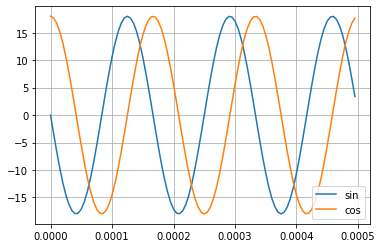

In [4]:
# make quadrature components
y_sin = AMPL_G * np.cos(2 * np.pi * FREQ_G * x + np.pi/2.0) + OFFSET_G
y_cos = AMPL_G * np.cos(2 * np.pi * FREQ_G * x) + OFFSET_G

plt.plot(x[:100], y_sin[:100], label="sin")
plt.plot(x[:100], y_cos[:100], label="cos")
plt.legend()
plt.grid()
plt.show()

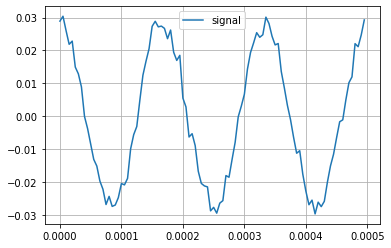

In [5]:
# make input signal
y_s = input_signal(SAMPLE_RATE, DURATION, AMPL_S, FREQ_S, OFFSET_S, PHI_S)
noise = noise_gen(20, y_s**2) # noise with SNR = 20 db
y_s = y_s + noise

plt.plot(x[:100], y_s[:100], label="signal")
plt.legend()
plt.grid()
plt.show()

In [148]:
# notch filter - DC-blocker
notch_enable = False
R = 0.99997

y_s_f = [y_s[0]]
for i in range(1, len(y_s)):
    if (notch_enable):
        y_s_f.append(y_s[i] - y_s[i-1] + R * y_s_f[i-1])
    else:
        y_s_f.append(y_s[i])

# startTime = 0 # seconds
# stopTime = 0.8 # seconds
# plt.plot(x[int(startTime * SAMPLE_RATE):int(stopTime * SAMPLE_RATE)], y_s_f[int(startTime * SAMPLE_RATE):int(stopTime * SAMPLE_RATE)], label="signal_f")
# plt.legend()
# plt.grid()
# plt.show()

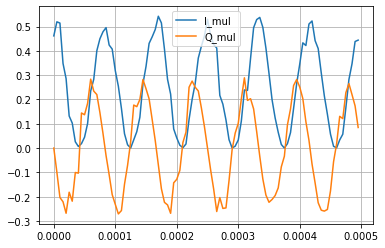

In [149]:
# step 1. Signal multiplier
I_mul = []
Q_mul = []

for i in range(len(y_s_f)):
    I_mul.append(y_s_f[i] * y_cos[i])
    Q_mul.append(y_s_f[i] * y_sin[i])
    
plt.plot(x[:100], I_mul[:100], label="I_mul")
plt.plot(x[:100], Q_mul[:100], label="Q_mul")
plt.legend()
plt.grid()
plt.show()

In [150]:
# stage 2. Output LPF (1st order)
f_cut = 20 # Hz
alpha = 2.0 * np.pi * f_cut / (SAMPLE_RATE + 2.0 * np.pi * f_cut)
print(f"alpha = {alpha}")

I_f = [I_mul[0] * alpha]
Q_f = [Q_mul[0] * alpha]

for i in range(1, len(y_s)):
    I_f.append(I_f[i-1] + alpha * (I_mul[i] - I_f[i-1]))
    Q_f.append(Q_f[i-1] + alpha * (Q_mul[i] - Q_f[i-1]))
    
# plt.plot(x, I_f, label="I_f")
# plt.plot(x, Q_f, label="Q_f")
# plt.legend()
# plt.grid()
# plt.show()

alpha = 0.0006279239944363719


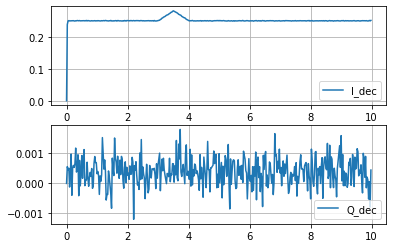

In [151]:
# step 3. Decimator
DEC_degree = 5000 # each N-th point will be get from stream

I_dec = []
Q_dec = []
x_dec = []

for i in range(0, len(y_s), DEC_degree):
    I_dec.append(I_f[i])
    Q_dec.append(Q_f[i])
    x_dec.append(x[i])

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(x_dec, I_dec, label="I_dec")
ax2.plot(x_dec, Q_dec, label="Q_dec")

ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()
plt.show() 

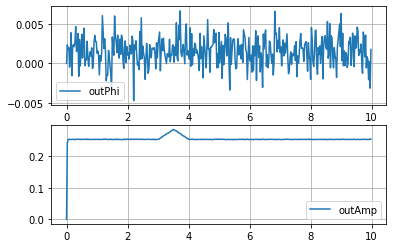

0.28343252213174375


In [152]:
# for control amplitude and phase of recovered signal
outAmp = []
outPhi = []

for i in range(len(x_dec)):
    outAmp.append(np.sqrt(I_dec[i]**2 + Q_dec[i]**2))
    outPhi.append(np.arctan2(Q_dec[i], I_dec[i]))

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(x_dec, outPhi, label="outPhi")
ax2.plot(x_dec, outAmp, label="outAmp")

ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()
plt.show() 

print(f"{max(outAmp)}")

bpf_1 = 0.9009368224080968
bpf_2 = 0.7585469929947761


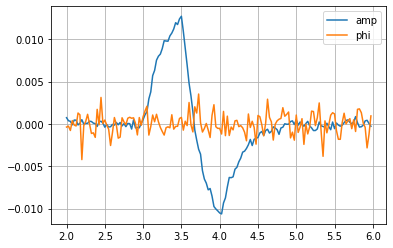

In [155]:
# step 4 (optional). Band-pass filter

# HPF (1st order)
f_cut_hpf = 0.7 # Hz
bpf_1 = (SAMPLE_RATE / DEC_degree) / ((SAMPLE_RATE / DEC_degree) + 2.0 * np.pi * f_cut_hpf)
print(f"bpf_1 = {bpf_1}")

amp_bpf_1 = [outAmp[0] * bpf_1]
phi_bpf_1 = [outPhi[0] * bpf_1]

for i in range(1, len(x_dec)):
    amp_bpf_1.append(bpf_1 * (amp_bpf_1[i-1] + outAmp[i] - outAmp[i-1]))
    phi_bpf_1.append(bpf_1 * (phi_bpf_1[i-1] + outPhi[i] - outPhi[i-1]))
    
# LPF (1st order)
f_cut_lpf = 20 # Hz
bpf_2 = 2.0 * np.pi * f_cut_lpf / ( (SAMPLE_RATE / DEC_degree) + 2.0 * np.pi * f_cut_lpf)
print(f"bpf_2 = {bpf_2}")

amp_bpf_2 = [amp_bpf_1[0] * bpf_2]
phi_bpf_2 = [phi_bpf_1[0] * bpf_2]
for i in range(1, len(x_dec)):
    amp_bpf_2.append(amp_bpf_2[i-1] + bpf_2 * (amp_bpf_1[i] - amp_bpf_2[i-1]))
    phi_bpf_2.append(phi_bpf_2[i-1] + bpf_2 * (phi_bpf_1[i] - phi_bpf_2[i-1]))
    
    
startTime = 2 # seconds
stopTime = 6 # seconds
plt.plot(x_dec[int(startTime * SAMPLE_RATE / DEC_degree):int(stopTime * SAMPLE_RATE / DEC_degree)], amp_bpf_2[int(startTime * SAMPLE_RATE / DEC_degree):int(stopTime * SAMPLE_RATE / DEC_degree)], label="amp")
plt.plot(x_dec[int(startTime * SAMPLE_RATE / DEC_degree):int(stopTime * SAMPLE_RATE / DEC_degree)], phi_bpf_2[int(startTime * SAMPLE_RATE / DEC_degree):int(stopTime * SAMPLE_RATE / DEC_degree)], label="phi")
# plt.plot(x_dec, amp_bpf_2, label="amp")
# plt.plot(x_dec, phi_bpf_2, label="phi")
plt.legend()
plt.grid()
plt.show()